In [1]:
import pandas as pd
import maya

from nucypher.utilities.sandbox.constants import INSECURE_DEVELOPMENT_PASSWORD
from nucypher.utilities.sandbox.blockchain import TesterBlockchain

from nucypher.blockchain.eth.agents import NucypherTokenAgent, StakingEscrowAgent
from nucypher.blockchain.economics import StandardTokenEconomics
from nucypher.blockchain.eth.agents import ContractAgency

##### Experimental max error

In [2]:
MAX_ERROR_FIRST_PHASE = 1e-8
MAX_ERROR_SECOND_PHASE = 0.00003
MAX_PERIODS_SECOND_PHASE = 1750

TEST_GAS_LIMIT = 8_000_000  # gas

#### Experimental Economics

In [3]:
ECONOMICS = StandardTokenEconomics()
SWITCH = ECONOMICS.first_phase_final_period()
DURATION = range(1, SWITCH + MAX_PERIODS_SECOND_PHASE)

##### Test blockchain settings

In [4]:
# Monkey patch to prevent gas adjustment
import eth
eth._utils.headers.GAS_LIMIT_MINIMUM = TEST_GAS_LIMIT
eth._utils.headers.GENESIS_GAS_LIMIT = TEST_GAS_LIMIT
eth.vm.forks.frontier.headers.GENESIS_GAS_LIMIT = TEST_GAS_LIMIT

# Monkey patch to prevent gas estimates
def _get_buffered_gas_estimate(web3, transaction, gas_buffer=100000):
    return TEST_GAS_LIMIT

import web3
web3.eth.get_buffered_gas_estimate = _get_buffered_gas_estimate

#### Deploy Experimental Network

In [5]:
# Deploy nucypher
testerchain, test_registry = TesterBlockchain.bootstrap_network(economics=ECONOMICS)

Broadcasting DEPLOY Transaction (0.000635186 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.00516188 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.000807469 gwei @ 1)...
Broadcasting APPROVE Transaction (0.000052869 gwei @ 1)...
Broadcasting INITIALIZE Transaction (0.000114835 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.003016032 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.000976887 gwei @ 1)...
Broadcasting SETPOLICYMANAGER Transaction (0.000068181 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.003285936 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.000792068 gwei @ 1)...
Broadcasting SETADJUDICATOR Transaction (0.000068181 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.001388338 gwei @ 1)...
Broadcasting DEPLOY Transaction (0.000271311 gwei @ 1)...


In [6]:
# Get accounts
deployer = testerchain.etherbase_account
ursula = testerchain.ursula_account(0)

# Get agents for deployed contracts
token_agent = ContractAgency.get_agent(NucypherTokenAgent, registry=test_registry)
staking_agent = ContractAgency.get_agent(StakingEscrowAgent, registry=test_registry)

print(f'Deployer: {deployer}')
print(f'Ursua: {ursula}')
print(f'Token: {token_agent.contract_address}')
print(f'Escrow: {staking_agent.contract_address}')

Deployer: 0x7E5F4552091A69125d5DfCb7b8C2659029395Bdf
Ursua: 0xfaE394561e33e242c551d15D4625309EA4c0B97f
Token: 0xF2E246BB76DF876Cef8b38ae84130F4F55De395b
Escrow: 0xDe09E74d4888Bc4e65F589e8c13Bce9F71DdF4c7


##### Prepare one worker/staker

In [7]:
# Send tokens
token_agent.transfer(amount=ECONOMICS.minimum_allowed_locked,
                     target_address=ursula,
                     sender_address=deployer)

# mock_transacting_power_activation(account=ursula, password=INSECURE_DEVELOPMENT_PASSWORD)

# Approve transfer of tokens to StakingEscrow
token_agent.approve_transfer(amount=ECONOMICS.minimum_allowed_locked,
                             target_address=staking_agent.contract_address,
                             sender_address=ursula)

# Deposit tokens into StakingEscrow
staking_agent.deposit_tokens(amount=ECONOMICS.minimum_allowed_locked,
                             lock_periods=100 * ECONOMICS.maximum_rewarded_periods,
                             sender_address=ursula,
                             staker_address=ursula)

# Bond a worker and enable restaking
staking_agent.set_worker(staker_address=ursula, worker_address=ursula)
staking_agent.set_restaking(staker_address=ursula, value=False)

print(f"Ursula: {ursula}")

Broadcasting TRANSFER Transaction (0.000052821 gwei @ 1)...
Broadcasting APPROVE Transaction (0.0005 gwei @ 1)...
Broadcasting DEPOSIT Transaction (0.00030229 gwei @ 1)...
Broadcasting SETWORKER Transaction (0.000083764 gwei @ 1)...
Broadcasting SETRESTAKE Transaction (0.000052359 gwei @ 1)...
Ursula: 0xfaE394561e33e242c551d15D4625309EA4c0B97f


##### Confirm the first two periods

In [8]:
# First Period
staking_agent.confirm_activity(worker_address=ursula)

# Second Period
testerchain.time_travel(periods=1)
staking_agent.confirm_activity(worker_address=ursula)
assert staking_agent.calculate_staking_reward(staker_address=ursula) == 0

Broadcasting CONFIRMACTIVITY Transaction (0.000161317 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000098982 gwei @ 1)...


##### Collect Data

This step will take some time to run... get some coffee ☕

In [9]:
PHASE_ONE_RESULTS = {}
PHASE_TWO_RESULTS = {}


start_time = maya.now()

for i in DURATION:
    
    # Confirm Activity
    testerchain.time_travel(periods=1)
    staking_agent.confirm_activity(worker_address=ursula)
    
    # Calculate reward and error
    contract_reward = staking_agent.calculate_staking_reward(staker_address=ursula)
    calculations_reward = ECONOMICS.cumulative_rewards_at_period(i)
    error = abs((contract_reward - calculations_reward) / calculations_reward)
    
    # Record results
    
    # Phase 1
    if i <= SWITCH:
        record = dict(period=i,
                      reward=calculations_reward,
                      error=error, 
                      threshold=MAX_ERROR_FIRST_PHASE)
        PHASE_ONE_RESULTS[i] = record
    
    # Phase 2
    else:
        record = dict(period=i,
                      reward=calculations_reward,
                      error=error, 
                      threshold=MAX_ERROR_SECOND_PHASE)
        PHASE_TWO_RESULTS[i] = record

finish_time = maya.now()


Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1

Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000208069 gwei @ 1)...
Broadcasting CONFIRMACTIVITY Transaction (0.000239237 gwei @ 1)...


In [10]:
delta = str((finish_time - start_time))
print(delta)

0:19:58


In [11]:
phase_one_errors = [record['error'] for record in PHASE_ONE_RESULTS.values()]
phase_two_errors = [record['error'] for record in PHASE_TWO_RESULTS.values()]
all_errors = [*phase_one_errors, *phase_two_errors]

### Phase 1

##### Phase 1 Error

In [12]:
p1df = pd.DataFrame(phase_one_errors)
p1df.describe()

,0
count,1.825000e+03
mean,9.428360e-25
std,4.466294e-27
min,8.977471e-25
25%,9.423624e-25
50%,9.426345e-25
75%,9.429074e-25
max,9.974968e-25


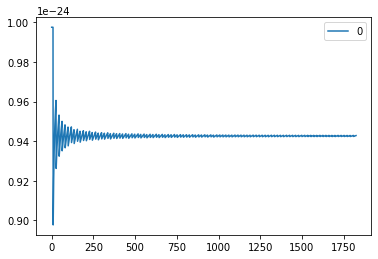

In [13]:
import matplotlib.pyplot as plt

p1df.plot(kind='line')
plt.show()

##### Phase one Reward

In [14]:
phase_one_reward = [record['reward'] for record in PHASE_ONE_RESULTS.values()]
p1rdf = pd.DataFrame(phase_one_reward)
p1rdf.describe()

,0
count,1825
unique,1825
top,1304264832767123287671232876
freq,1


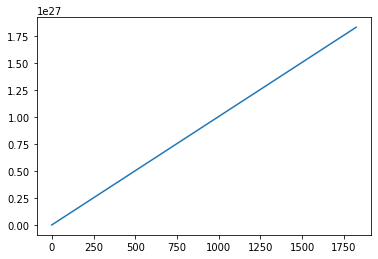

In [15]:
plot = plt.plot(range(len(phase_one_reward)), phase_one_reward)

### Phase 2 Results

##### Phase 2 Error

In [16]:
p2df = pd.DataFrame(phase_two_errors)
p2df.describe()

,0
count,1.749000e+03
mean,8.242925e-05
std,2.226088e-05
min,3.469680e-07
25%,8.009570e-05
50%,9.035453e-05
75%,9.739441e-05
max,9.991108e-05


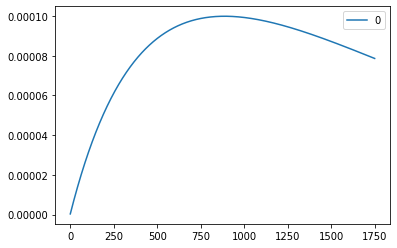

In [17]:
p2df.plot(kind='line')
plt.show()

##### Phase 2 Rewards

In [18]:
phase_two_reward = [record['reward'] for record in PHASE_TWO_RESULTS.values()]
p2rdf = pd.DataFrame(phase_two_reward)
p2rdf.describe()

,0
count,1749
unique,1749
top,2064456777466560485718053422
freq,1


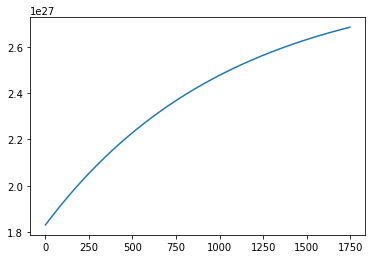

In [19]:
plot = plt.plot(range(len(phase_two_reward)), phase_two_reward)

### Total Error

In [20]:
all_df = pd.DataFrame(all_errors)
all_df.describe()

,0
count,3.574000e+03
mean,4.033821e-05
std,4.405436e-05
min,8.977471e-25
25%,9.426259e-25
50%,9.462113e-25
75%,8.995891e-05
max,9.991108e-05


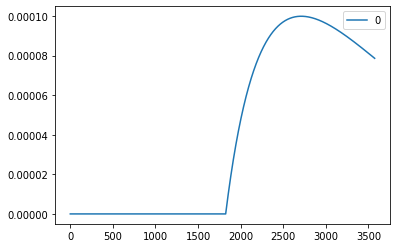

In [22]:
all_df.plot(kind='line')
plt.show()

##### Total Reward

In [23]:
total_reward = [*phase_one_reward, *phase_two_reward]
total_reward_df = pd.DataFrame(phase_two_reward)
total_reward_df.describe()

,0
count,1749
unique,1749
top,2064456777466560485718053422
freq,1


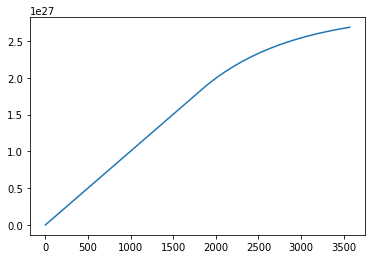

In [24]:
plot = plt.plot(range(len(total_reward)), total_reward)

### Dataset

In [25]:
PHASE_ONE_RESULTS


{1: {'period': 1,
  'reward': 1002509479452054794520548,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 2: {'period': 2,
  'reward': 2005018958904109589041096,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 3: {'period': 3,
  'reward': 3007528438356164383561644,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 4: {'period': 4,
  'reward': 4010037917808219178082192,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 5: {'period': 5,
  'reward': 5012547397260273972602740,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 6: {'period': 6,
  'reward': 6015056876712328767123288,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 7: {'period': 7,
  'reward': 7017566356164383561643836,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 8: {'period': 8,
  'reward': 8020075835616438356164384,
  'error': 9.9749680227121e-25,
  'threshold': 1e-08},
 9: {'period': 9,
  'reward': 9022585315068493150684932,
  'error': 9.9749680227121e-25,
  'threshold': 

In [26]:
PHASE_TWO_RESULTS

{1826: {'period': 1826,
  'reward': 1830581833680317886921600276,
  'error': 3.469679636900725e-07,
  'threshold': 3e-05},
 1827: {'period': 1827,
  'reward': 1831582916364501478928481102,
  'error': 6.928982052671205e-07,
  'threshold': 3e-05},
 1828: {'period': 1828,
  'reward': 1832583048955108908754224895,
  'error': 1.0377939005332694e-06,
  'threshold': 3e-05},
 1829: {'period': 1829,
  'reward': 1833582232353841721861880629,
  'error': 1.3816582132769094e-06,
  'threshold': 3e-05},
 1830: {'period': 1830,
  'reward': 1834580467461545689401850355,
  'error': 1.7244942953291067e-06,
  'threshold': 3e-05},
 1831: {'period': 1831,
  'reward': 1835577755178211620398224988,
  'error': 2.0663052866196973e-06,
  'threshold': 3e-05},
 1832: {'period': 1832,
  'reward': 1836574096402976173164301629,
  'error': 2.407094315233065e-06,
  'threshold': 3e-05},
 1833: {'period': 1833,
  'reward': 1837569492034122665948013980,
  'error': 2.7468644974636046e-06,
  'threshold': 3e-05},
 1834: {'pe